In [1]:
%store -r merged_df

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

#auto arima time series modeling package
from pmdarima import auto_arima

## MODEL PREP AND MODELING DATA

Check for Stationarity. Quick look at trends yoy by dea class

need to use date as index. group by product_fda_list_name and qtr_begin_dt to sum units/amounts

In [3]:
grouped_df = merged_df.groupby(['qtr_begin_dt','mat_x','opioid','dea_schedule','product_fda_list_name']).sum()


In [4]:
grp_dea_sched_df = merged_df.groupby(['qtr_begin_dt','mat_x','opioid','dea_schedule']).sum().reset_index()

In [5]:
grp_dea_sched_df.set_index(pd.DatetimeIndex(grp_dea_sched_df['qtr_begin_dt']), inplace = True)
grp_dea_sched_df.drop(columns = ['qtr_begin_dt'], inplace = True)

In [6]:
grp_dea_sched_df.head()

,mat_x,opioid,dea_schedule,total_amount_reimbursed,units_reimbursed,total_medicaid_enrollees,units_per_1000,amount_per_1000
qtr_begin_dt,,,,,,,,
2015-01-01,0,1,CII,3480933.12,6858087.43,325313532.0,5502.263642,2792.762842
2015-01-01,0,1,CIII,220893.23,335836.00,46117244.0,269.442207,177.223286
2015-01-01,0,1,CIV,94139.87,841797.00,27421064.0,675.376200,75.528694
2015-01-01,0,1,CV,2722.34,66911.78,8724884.0,53.683517,2.184141
2015-01-01,1,1,CII,31869.02,189851.00,7478472.0,152.318014,25.568608


In [32]:
CII = grp_dea_sched_df.loc[grp_dea_sched_df['dea_schedule']== 'CII']
CIII = grp_dea_sched_df.loc[grp_dea_sched_df['dea_schedule']== 'CIII']

CIV = grp_dea_sched_df.loc[grp_dea_sched_df['dea_schedule']== 'CIV']

CV = grp_dea_sched_df.loc[grp_dea_sched_df['dea_schedule']== 'CV']



In [33]:
CII.head()

,mat_x,opioid,dea_schedule,total_amount_reimbursed,units_reimbursed,total_medicaid_enrollees,units_per_1000,amount_per_1000
qtr_begin_dt,,,,,,,,
2015-01-01,0,1,CII,3480933.12,6858087.43,325313532.0,5502.263642,2792.762842
2015-01-01,1,1,CII,31869.02,189851.00,7478472.0,152.318014,25.568608
2015-04-01,0,1,CII,2331363.77,4306551.47,318385376.0,3354.503206,1815.969760
2015-04-01,1,1,CII,5094.11,25444.00,8986684.0,19.819101,3.967956
2015-07-01,0,1,CII,1351597.55,3576911.91,305441523.0,2845.682491,1075.289965


try an ARIMA on CIII non-MAT

In [34]:
CII_Non_MAT = CII.loc[CII['mat_x']== 0]
CIII_Non_MAT = CIII.loc[CIII['mat_x']== 0]
CIV_Non_MAT = CIV.loc[CIV['mat_x']== 0]
CV_Non_MAT = CV.loc[CV['mat_x']== 0]



In [35]:
CV_Non_MAT['units_per_1000'].unique()

array([ 53.68351717,  75.47561481,  82.80398517, 105.9247461 ,
       320.36087672,  32.12030059,   9.58845487,   9.94683614,
       341.29310241, 215.7555798 , 168.01828742, 239.01890156,
       238.83003207, 134.15184299, 113.63327392, 165.432703  ,
       182.39701706,  96.97677992,   0.        ])

In [36]:
CII_Non_MAT.loc[:,"units_per_1000"] = pd.to_numeric(CII_Non_MAT["units_per_1000"], errors = "coerce")
CIII_Non_MAT.loc[:,"units_per_1000"] = pd.to_numeric(CIII_Non_MAT["units_per_1000"], errors = "coerce")
CIV_Non_MAT.loc[:,"units_per_1000"] = pd.to_numeric(CIV_Non_MAT["units_per_1000"], errors = "coerce")
CV_Non_MAT.loc[:,"units_per_1000"] = pd.to_numeric(CV_Non_MAT["units_per_1000"], errors = "coerce")

/Users/shishi/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [37]:
CV_Non_MAT['units_per_1000'].describe

<bound method NDFrame.describe of qtr_begin_dt
2015-01-01     53.683517
2015-04-01     75.475615
2015-07-01     82.803985
2015-10-01    105.924746
2016-01-01    320.360877
2016-04-01     32.120301
2016-07-01      9.588455
2016-10-01      9.946836
2017-01-01    341.293102
2017-04-01    215.755580
2017-07-01    168.018287
2017-10-01    239.018902
2018-01-01    238.830032
2018-04-01    134.151843
2018-07-01    113.633274
2018-10-01    165.432703
2019-01-01    182.397017
2019-04-01     96.976780
2019-07-01      0.000000
2019-10-01      0.000000
Name: units_per_1000, dtype: float64>

In [ ]:
CIII_Non_MAT.head()

In [43]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    plt.figure(figsize=(14,5))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=18)
    plt.xlabel(xlab, fontsize=14)
    plt.ylabel(ylab, fontsize=14)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=14)
    plt.xticks(df.index[0::steps], fontsize=14);

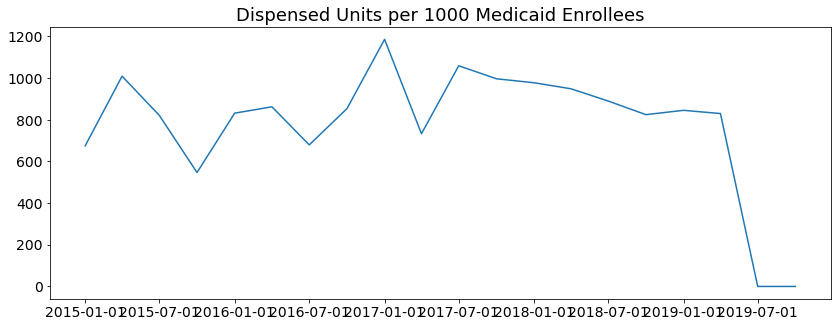

In [48]:
plot_series(CIV_Non_MAT,['units_per_1000'], title = "Dispensed Units per 1000 Medicaid Enrollees", steps = 2)

In [38]:
grp_dea_sched_df.columns

Index(['mat_x', 'opioid', 'dea_schedule', 'total_amount_reimbursed',
       'units_reimbursed', 'total_medicaid_enrollees', 'units_per_1000',
       'amount_per_1000'],
      dtype='object')

In [42]:
grp_dea_sched_df[grp_dea_sched_df['units_per_1000']== 0]

,mat_x,opioid,dea_schedule,total_amount_reimbursed,units_reimbursed,total_medicaid_enrollees,units_per_1000,amount_per_1000
qtr_begin_dt,,,,,,,,
2019-07-01,0,1,CII,2168360.00,8685645.30,0.0,0.0,0.0
2019-07-01,0,1,CIII,169803.87,480586.00,0.0,0.0,0.0
2019-07-01,0,1,CIV,242441.00,1046975.00,0.0,0.0,0.0
2019-07-01,0,1,CV,3054.31,106680.00,0.0,0.0,0.0
2019-07-01,1,1,CII,12927.66,102482.00,0.0,0.0,0.0
2019-07-01,1,1,CIII,13417963.30,3642978.96,0.0,0.0,0.0
2019-07-01,1,1,CIV,10436.53,980.00,0.0,0.0,0.0
2019-10-01,0,1,CII,1173365.89,5422014.50,0.0,0.0,0.0
2019-10-01,0,1,CIII,90569.52,293078.00,0.0,0.0,0.0
